# Demo de Deep Convolutional Inverse Graphics Network (DCIGN) para colorear las imágenes

In [ ]:
#@title Librerías a usar
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical

import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import random
import copy

import ipywidgets as widgets
from ipywidgets import Box, Layout

from PIL import Image

print("\nLibrerías importadas")


Librerías importadas


##Imágenes:

In [ ]:
#@title Acceder al Drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/ANIMALES' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


In [ ]:
#@title Cargar Imágenes usando en blanco y negro para, y color para salida

#@markdown ### Parámetros para imágenes:
imagen_ancho = 128 #@param {type:"integer"}
imagen_largo = 128 #@param {type:"integer"}

# tamaño de las imágenes
if imagen_ancho<=10:
  imagen_largo = 10
if imagen_largo<=10:
  imagen_largo = 10
IMAGE_SHAPE = (imagen_ancho, imagen_largo, 3)

# indica si se usan las imágenes generadas por data augmentation
usarDA = False

# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = []
  images_ori = []
  esDA_ori = []
  images_sal = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:

            esImagDA = (each_imagFN[:2] == 'da')

            # abre la imagen
            imag = Image.open(auxiPath + "/" + each_imagFN)

            # ajusta el tamaño
            tipoImage = 'RGB'
            imag = imag.convert('RGB')
            imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)

            imag2 = imag.convert('L')
            imag2 = imag2.convert('RGB')

            # transforma a un vector de nros
            arImag = np.array(imag)
            arImag2 = np.array(imag2)

            # agrega a los vectores
            classes_ori.append( each_dir )
            images_ori.append( arImag2 )
            images_sal.append( arImag )
            esDA_ori.append( esImagDA )

  return classes_ori, images_ori, images_sal, esDA_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train_IN, images_train_OUT, esDAimag_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(classes_train))
print("- Imágenes cargadas: ", len(images_train_IN))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train_IN[0].shape, " ", images_train_OUT[0].shape,  ": ")
  display( Image.fromarray(images_train_IN[0], tipoImage_train) )
  display( Image.fromarray(images_train_OUT[0], tipoImage_train) )

# carga las imagenes de prueba
classes_test, images_test_IN, images_test_OUT, esDAimag_test, tipoImage_test = cargarImagenes(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(classes_test))
print("- Imágenes cargadas: ", len(images_test_IN))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test_IN[0].shape, " ", images_test_OUT[0].shape, ": ")
  display( Image.fromarray(images_test_IN[0], tipoImage_test) )
  display( Image.fromarray(images_test_OUT[0], tipoImage_test) )

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (144, 128, 128, 3) / (144, 128, 128, 3)
 - y_trainEnc (cant):  144
 - y_train (cant):  144


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (144, 128, 128, 3) / (144, 128, 128, 3)
 - y_testEnc (cant):  36
 - y_test (cant):  36


> Para Ambos: 
 - dictMapeo:  {'zorro': 0, 'leon': 1, 'gato': 2, 'perro': 3, 'lobo': 4, 'tigre': 5}
 - CLASES:  ['zorro', 'leon', 'gato', 'perro', 'lobo', 'tigre']

 - Imagen ejemplo de  gato ( 2  /  [0. 0. 1. 0. 0. 0.] )


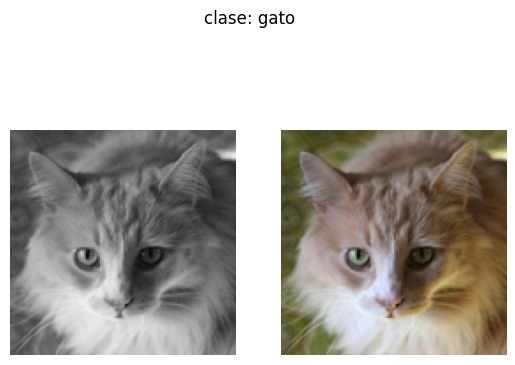

In [ ]:
#@title Preparar imágenes para usar en el modelo

# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE).astype(np.uint8))
  plt.axis("off")

def plot_images(clase, imag_IN, imag_OUT, imag_MODELO=None):
    # prepara para mostrar
    fig = plt.figure()
    fig.suptitle( "clase: " + str( clase ) )

    # muestra la real de entrada
    ax1 = fig.add_subplot(121)
    plot_image( imag_IN )

    ax3 = fig.add_subplot(122)
    if not(imag_MODELO is None):
      # muestra la generada por el modelo
      plot_image( imag_MODELO )
      # muestra la real deseada
      ax2 = fig.add_subplot(331)

    plot_image( imag_OUT )

    #plt.tight_layout()
    fig = plt.gcf()

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):
  auxiAr = np.array(imagList).astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
  return auxiAr

# define función auxiliar para preparar lista de clases
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  # convierte valores numéricos a columnas de vakores binarios (i.e. one hot encoded)
  dummy_y = to_categorical(y)
  # devuelve
  return np.array(y), np.array(dummy_y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train_IN = prepare_imageList(images_train_IN)
x_train_OUT = prepare_imageList(images_train_OUT)
x_test_IN = prepare_imageList(images_test_IN)
x_test_OUT = prepare_imageList(images_test_OUT)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, y_trainEnc, dictMapeo = prepare_clasesList(classes_train)
y_test, y_testEnc,_ = prepare_clasesList(classes_test, dictMapeo)

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
CLASES = [ x for x,y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train_IN.shape, "/",  x_train_OUT.shape)
print(" - y_trainEnc (cant): ", len(y_trainEnc))
print(" - y_train (cant): ", len(y_train))
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_train_IN.shape, "/",  x_train_OUT.shape)
print(" - y_testEnc (cant): ", len(y_testEnc))
print(" - y_test (cant): ", len(y_test))
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - CLASES: ", CLASES)
if len(y_train)>0:
  print("\n - Imagen ejemplo de ", CLASES[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  plot_images(CLASES[y_train[0]], x_train_IN[0], x_train_OUT[0])


##Modelo:

Modelo DAE CNN creado con  29  capas:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "DCIGNmodel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)               │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ c_enc_1 (Conv2D)                     │ (None, 128, 128, 64)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cl_enc_1 (LeakyReLU)                 │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_enc_1 (MaxPooling2D)               │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ c_enc_2 (Conv2D)                     │ (None, 64, 64, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cl_enc_2 (LeakyReLU)                 │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_enc_2 (MaxPooling2D)               │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ c_enc_3 (Conv2D)                     │ (None, 32, 32, 16)          │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cl_enc_3 (LeakyReLU)                 │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_enc_3 (MaxPooling2D)               │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ c_enc_4 (Conv2D)                     │ (None, 16, 16, 8)           │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cl_enc_4 (LeakyReLU)                 │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_enc_4 (MaxPooling2D)               │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_features (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ d_features (Dense)                   │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ r_features (Reshape)                 │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ d_dec_5 (Conv2DTranspose)            │ (None, 16, 16, 8)           │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dl_dec_5 (LeakyReLU)                 │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dn_dec_5 (BatchNormalization)        │ (None, 16, 16, 8)           │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ d_dec_4 (Conv2DTranspose)            │ (None, 32, 32, 16)          │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dl_dec_4 (LeakyReLU)                 │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 286,675 (1.09 MB)

 Trainable params: 286,435 (1.09 MB)

 Non-trainable params: 240 (960.00 B)

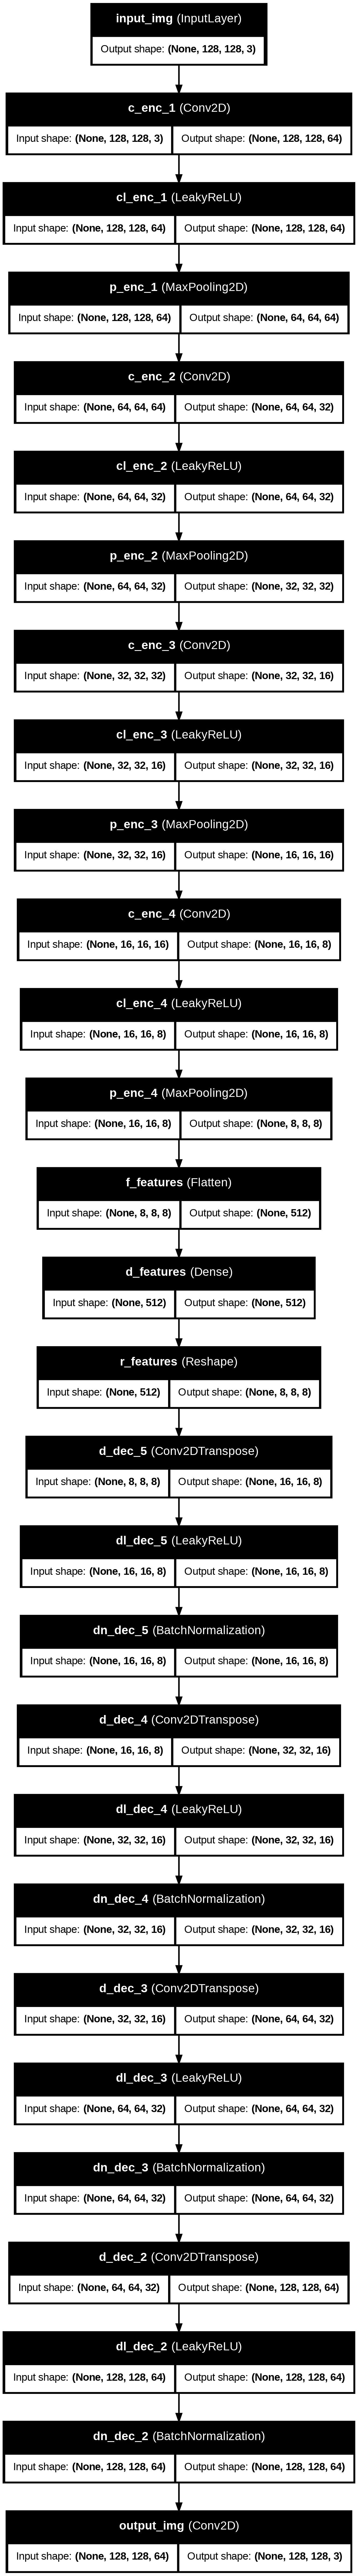

In [ ]:
#@title Establecer modelo

#@markdown ### Parámetros de las capas ConvNet:
convNet_tamaño_kernel_NxN = 2 #@param {type:"integer"}
convNet_tamaño_pooling_MxM =  2#@param {type:"integer"}
convNet_cantidad_capas_ocultas =  4#@param {type:"integer"}
convNet_tipo_capas = 'LeakyReLU' #@param [ 'Conv2D + UpSampling', 'Conv2DTranspose + BatchNormalization', 'LeakyReLU']

#@markdown ### Parámetros del Optimizador:
opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.001 #@param {type: "number"}

## aplicación de los parámetros elegidos

# tamaño de los kernels y pooling (para simplificar son todas iguales)
if convNet_tamaño_kernel_NxN<1:
  convNet_tamaño_kernel_NxN = 1
dae_kernel_shape = (convNet_tamaño_kernel_NxN, convNet_tamaño_kernel_NxN)
if convNet_tamaño_pooling_MxM<1:
  convNet_tamaño_pooling_MxM=1
dae_pooling_shape = (convNet_tamaño_pooling_MxM, convNet_tamaño_pooling_MxM)

# indica la configuración para la parte Encoder
#   (cada elemento de las listas son la configuración de las capas Conv)
if convNet_cantidad_capas_ocultas<1:
  convNet_cantidad_capas_ocultas = 1
dae_filters = []
for i in range(convNet_cantidad_capas_ocultas, 0, -1):
  dae_filters.append( 2**(i+2) )

# la capa de features se define automáticamente
# en base a la información de la última capa del Encoder
dae_filters.append( 'f' )
dae_posLayFeat = len(dae_filters)-1

# cantidad de neuronas ocultas para la parte Decoder
#   (usa la la lista de Encoder inversa)
for eachEncFilter in dae_filters[0:len(dae_filters)-1][::-1]:
      dae_filters.append( eachEncFilter )

# indica si el Decoder usa:
#  ver 1: Conv2D + UpSampling (mejores colores pero fuera de foco)
#  ver 2: Conv2DTranspose + BatchNormalization (mejor nitidez pero como manchada)
if convNet_tipo_capas == 'Conv2D + UpSampling':
  verCapasDecoder = 1
elif convNet_tipo_capas == 'LeakyReLU':
  verCapasDecoder = 3
else:
  verCapasDecoder = 2


if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam()


# define la arquitectura de capas del Deep Autoencoder CNN
# teniendo en cuenta la definición dada anteriomente
input_img_Lay = tf.keras.layers.Input(shape=IMAGE_SHAPE, name='input_img') # capa de entrada
eachLay = input_img_Lay
auxName = 'enc_'
auxId = 1
for i in range(len(dae_filters)):

    # define el nombre de la capa oculta
    auxlayerName = auxName+str(auxId)
    if i==dae_posLayFeat:
        auxlayerName = 'features'
        auxName = 'dec_'
    else:
        if auxName == 'enc_':
          auxId = auxId + 1
        else:
          auxId = auxId - 1

    # agrega las capas ocultas
    if auxlayerName.startswith('enc_'):
        if verCapasDecoder == 3:
          # agrega capa Conv2D + LeakyReLU para Encoder
          eachLay = tf.keras.layers.Conv2D(dae_filters[i], dae_kernel_shape, padding='same', name='c_'+auxlayerName)(eachLay)
          eachLay = tf.keras.layers.LeakyReLU(alpha=0.2, name='cl_'+auxlayerName)(eachLay)
        else:
          # agrega capa Conv2D para Encoder
          eachLay = tf.keras.layers.Conv2D(dae_filters[i], dae_kernel_shape, activation='relu', padding='same', name='c_'+auxlayerName)(eachLay)
        # agrega capa MaxPooling para Encoder
        eachLay = tf.keras.layers.MaxPooling2D(dae_pooling_shape, padding='same', name='p_'+auxlayerName)(eachLay)

    elif auxlayerName.startswith('dec_'):
      if verCapasDecoder == 2:
          # Dec v2: agrega capa Conv2DTranspose con BatchNormalization para Decoder
          eachLay = tf.keras.layers.Conv2DTranspose(dae_filters[i], dae_kernel_shape, strides=2, activation='relu', padding='same', name='d_'+auxlayerName)(eachLay)
          eachLay = tf.keras.layers.BatchNormalization(name='p_'+auxlayerName)(eachLay)
      elif verCapasDecoder == 3:
          # Dec v3: agrega capa Conv2DTranspose con LeakyReLU y BatchNormalization para Decoder
          eachLay = tf.keras.layers.Conv2DTranspose(dae_filters[i], dae_kernel_shape, strides=2, padding='same', name='d_'+auxlayerName)(eachLay)
          eachLay = tf.keras.layers.LeakyReLU(alpha=0.2, name='dl_'+auxlayerName)(eachLay)
          eachLay = tf.keras.layers.BatchNormalization(axis=-1, name='dn_'+auxlayerName)(eachLay)
      else:
          # Dec v1: agrega capa Conv2 + UpSampling2D para Decoder
          eachLay = tf.keras.layers.Conv2D(dae_filters[i], dae_kernel_shape, activation='relu', padding='same', name='d_'+auxlayerName)(eachLay)
          eachLay = tf.keras.layers.UpSampling2D(dae_pooling_shape, name='p_'+auxlayerName)(eachLay)

    elif auxlayerName.startswith('features'):
          #  agrega capa Flatten, Dense y Reshape
          # para ello utiliza la información del shape de la última capa Encoder
          ##dae_features_shape = (int(eachLay.shape[1]), int(eachLay.shape[2]), IMAGE_SHAPE[2])
          dae_features_shape = (int(eachLay.shape[1]), int(eachLay.shape[2]),  int(eachLay.shape[3]))
          num_features = dae_features_shape[0]*dae_features_shape[1]*dae_features_shape[2]

          eachLay = tf.keras.layers.Flatten(name='f_'+auxlayerName)(eachLay)
          eachLay = tf.keras.layers.Dense(num_features, activation='sigmoid', name='d_'+auxlayerName)(eachLay)
          features_Lay = eachLay
          eachLay = tf.keras.layers.Reshape(dae_features_shape, name='r_'+auxlayerName)(eachLay)

# agrega la capa de salida usando la cantidad de canales de la imagen como cantidad de filtros
output_img_Lay = tf.keras.layers.Conv2D(IMAGE_SHAPE[2], dae_kernel_shape, activation='tanh', padding='same', name='output_img')(eachLay)  # capa de salida

# controla que la cantidad de entradas y salidas sea igual
capas_entradas_salidas_diferentes = False
for in_s, out_s in zip(input_img_Lay.shape, output_img_Lay.shape):
  if in_s != out_s:
    capas_entradas_salidas_diferentes = True
    break
if capas_entradas_salidas_diferentes:
  raise Exception("La cantidad de entradas " + str(input_img_Lay.shape)+ " no coincide con la cantidad de salidas " + str(output_img_Lay.shape)+ ": ajuste los parámetros para capas convNet y/o  aumente el tamaño de las imágenes!")

# genera el modelo Deep Autoencoder
DCIGNmodel = Model(input_img_Lay, output_img_Lay, name='DCIGNmodel')
DCIGNmodel.compile(optimizer=opt, loss='mse', metrics=['RootMeanSquaredError'])

print("Modelo DAE CNN creado con ", len(DCIGNmodel.layers), " capas:")
DCIGNmodel.summary()
print("\n")
plot_model(DCIGNmodel, show_layer_names=True, show_shapes=True)

In [ ]:
#@title Entrenar

cant_epocas_entrenamiento =  2500 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
cantEpocas = (1 if cant_epocas_entrenamiento<1 else cant_epocas_entrenamiento)

# lleva a cabo el entrenamiento
# usando los mismos datos como entrada y salida
history = DCIGNmodel.fit(x_train_IN, x_train_OUT,
                epochs = cantEpocas,
                shuffle = True)

Se han truncado las últimas 5000 líneas del flujo de salida.
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - RootMeanSquaredError: 0.8185 - loss: 0.6704
Epoch 2/2500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - RootMeanSquaredError: 0.6858 - loss: 0.4705
Epoch 3/2500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - RootMeanSquaredError: 0.6082 - loss: 0.3700
Epoch 4/2500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - RootMeanSquaredError: 0.5567 - loss: 0.3099
Epoch 5/2500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - RootMeanSquaredError: 0.5195 - loss: 0.2699
Epoch 6/2500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - RootMeanSquaredError: 0.4888 - loss: 0.2389
Epoch 7/2500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - RootMeanSquaredError: 0.4660 - loss: 0.2171
Epoch 8/2500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - RootMeanSquaredError: 0.4465 - loss: 0.1994
Epoch 9/2500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - RootMeanSquaredError: 0.4260 - loss: 0.1815
Epoch 10/2500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - RootMeanSquaredError: 0.41

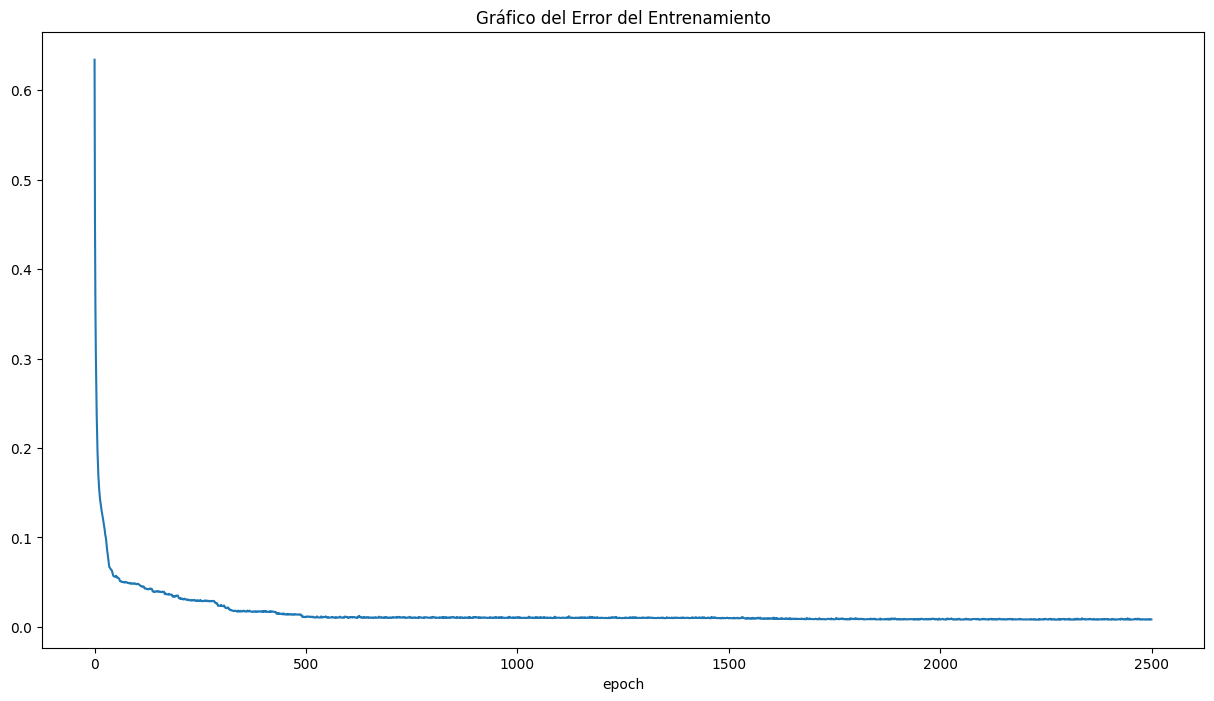

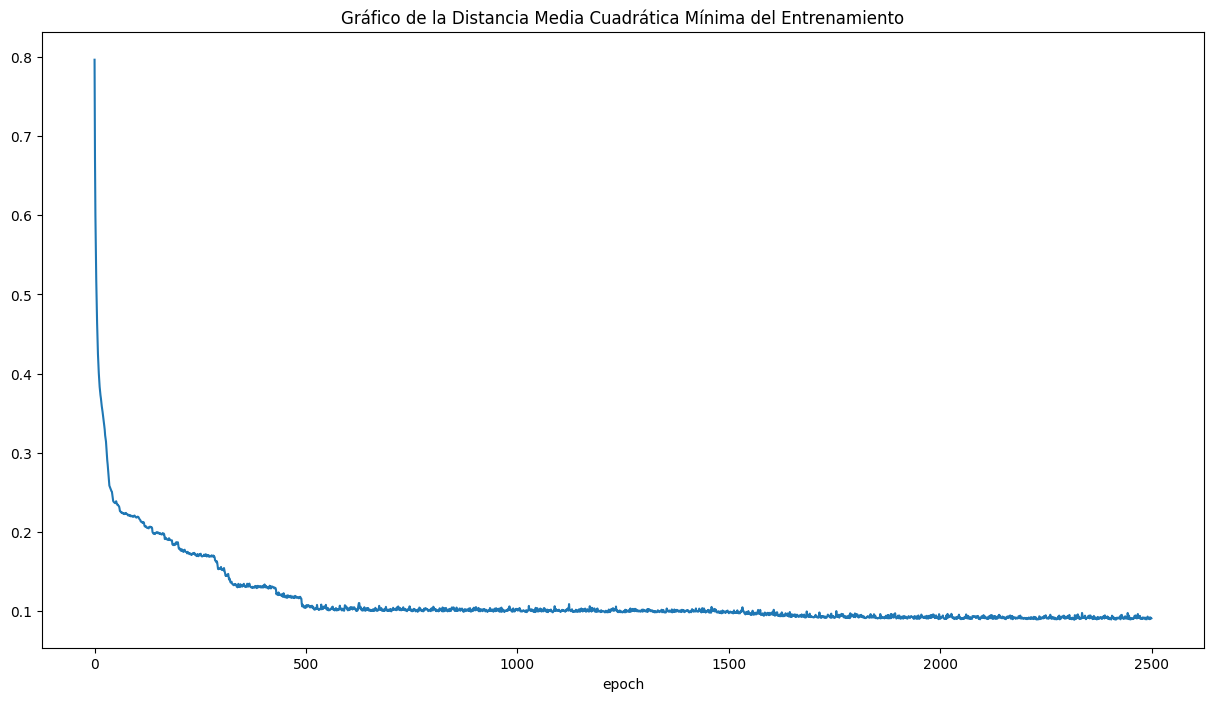

In [ ]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.show()

plt.figure(figsize=(15,8))
plt.plot(history.history['RootMeanSquaredError'])
plt.title('Gráfico de la Distancia Media Cuadrática Mínima del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.show()

In [ ]:
#@title Evaluar modelo con imágenes de Entrenamiento

# para sacar warning por cantidad de imágenes mostradas
plt.rcParams.update({'figure.max_open_warning': 0})

def agregarRuidoImagen(x_datos, gradoRuido):
  # copia datos para no cambiar original
  x_datos = copy.deepcopy(x_datos)
  # si es negativo, determina el grado al azar
  if gradoRuido < 0:
    gradoRuido = random.randint(0, 100)
  # agrega ruido al azar
  x_datos = x_datos + np.random.normal(loc=0.0, scale=gradoRuido/100, size=x_datos.shape)
  x_datos = np.clip(x_datos, 0., 1.)
  return x_datos


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x_in, x_out, y, esDAimag, claseFiltrar=None, gradoRuido=0.0):

  # determina clase a filtrar
  if (claseFiltrar is None) or (claseFiltrar == "TODOS"):
        clFiltrarID = None
  else:
        clFiltrarID = dictMapeo[claseFiltrar]

  # agrega ruido según corresponda
  if gradoRuido != 0.0:
    x_in = agregarRuidoImagen(x_in, gradoRuido)

    # procesa las imágenes con el modelo
  reconstr_imgs = DCIGNmodel.predict(x_in, verbose=0)
  cantMostradas = 0
  # muestra las 15 primeras imágenes
  for i in range(len(x_in)):
    # determina si filtra por clase
    if (clFiltrarID is None) or (clFiltrarID == y[i]):
    # no muestra las generadas por DA
    #if not esDAimag[i]:
          # prepara para mostrar
          plot_images(CLASES[y[i]], x_in[i], x_out[i], reconstr_imgs[i])
          cantMostradas = cantMostradas + 1
  print("\n\t Cantidad imágenes mostradas: ", cantMostradas, "\n")

# genera toda la interface para evaluar modeo DAE
def crearUI_evaluarModeloDAE(clDefecto, ruidoPorDefecto, funcionCambiaSeleccion):
  # prepara combo para filtrar por clase
  seleccion_CLASES = ["-", "TODOS"]
  seleccion_CLASES.extend( CLASES )
  seleccion_CLASES.sort()

  # auxiliar para que muestre bien la descripción
  style_3D = {'description_width': 'initial'}

  combo_clase = widgets.Dropdown(
      options = seleccion_CLASES,
      value = clDefecto,
      description = 'Filtrar por clase:',
      style=style_3D,
      disabled = False,
  )

  # prepara para seleccionar grado de ruido
  gradoRuidoImagenes = widgets.FloatSlider(
          value=ruidoPorDefecto,
          min=-1,
          max=100,
          step=1,
          description='Grado ruido para agregar:',
          style=style_3D,
          disabled=False,
          continuous_update=False,
          orientation='horizontal',
          readout=True,
          readout_format='.1f',)


  prueba_ui = widgets.GridBox(children=[combo_clase, gradoRuidoImagenes],
          layout=Layout(width='100%')
        )
  out_prueba = widgets.interactive_output(funcionCambiaSeleccion, {'cl':combo_clase, 'r':gradoRuidoImagenes})

  return prueba_ui, out_prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imEntrenamiento(cl, r):
  if (cl == "-"):
    return

  # prueba con los datos de entrenamiento
  print("*** Resultados con datos de Entrenamiento: clase "+cl)
  probarModelo(x_train_IN, x_train_OUT, y_train, esDAimag_train, cl, r)

# muestra la interface
ev_entrenamiento_ui, ev_entrenamiento_out = crearUI_evaluarModeloDAE( "TODOS", 0.0, cambiaSeleccion_clase_evaluar_imEntrenamiento )
display(ev_entrenamiento_ui, ev_entrenamiento_out)


In [ ]:
#@title Evaluar el modelo con las imágenes de prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imPrueba(cl, r):
  if (cl == "-"):
    return
  # prueba con los datos de entrenamiento
  print("*** Resultados con datos de Prueba: clase "+cl)
  probarModelo(x_test_IN, x_test_OUT, y_test, esDAimag_test, cl, r)

# muestra la interface
ev_prueba_ui, ev_prueba_out = crearUI_evaluarModeloDAE( "TODOS", 0.0, cambiaSeleccion_clase_evaluar_imPrueba )
display(ev_prueba_ui, ev_prueba_out)

In [ ]:
#@title Guardar Modelo entrenado

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoML/modelos/ImagDCIGN'  #@param {type:"string"}

if guardar_modelo:

    import os

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_model = path_modelo+"/model.keras"
    DCIGNmodel.save(fn_model)
    print("\n-Modelo guardado en ", fn_model,"\n")


    if ("IMAGE_SHAPE" in locals()) and (IMAGE_SHAPE is not None):
      fn_imageShape = path_modelo+"/IMAGE_SHAPE.txt"
      with open(fn_imageShape, 'w') as f:
        for i in IMAGE_SHAPE:
          f.write(str(i)+"\n")
      print("\n-IMAGE_SHAPE para cargar las imágenes guardado en ", path_modelo,"\n")


    if ("clases_map" in locals()) and (clases_map is not None):
      fn_clases = path_modelo+"/CLASES_MAP.txt"
      with open(fn_clases, 'w') as f:
        for i in range(len(clases_map)):
          f.write(str(i)+":"+str(clases_map[i])+"\n")
      print("\n-CLASES_MAP para mostrar los resultados guardado en ", path_modelo,"\n")

else:
    print("\n-Modelo no guardado.")


-Modelo guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/ImagDCIGN/model.keras 


-IMAGE_SHAPE para cargar las imágenes guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/ImagDCIGN 

